In [1]:
from Tools_Libraries import *
from IonModel_Libraries import *
from LimitSetting_Libraries import *
from WIMP_Libraries import *
from DP_Libraries import *
from Ultimate_Libraries import *

In [2]:
Exp = Experiment()
Exp.Information()

Detailed information about Experiment
Voltage =  0 V
Sigma =  10 eV
Sigmapercent =  0 %   pas encore utilisé
Fano =  1
IonModel =  CDMS  options are [CDMS,Rouven]
Target =  Ge options are [Ge,Si]
Epsilon =  3
Gap =  0.67
Exposure =  1  kg.days
Quenching =  EDW  options are [EDW,Lindhard_pure,Lindhard_corrected]
Target_uma =  72.64 uma


In [3]:
Exp.Target = "Ge"
Exp.Voltage = 100
Exp.SigmaeV = 10
Exp.Fano = 0.1
Exp.TriggerNsigma = 5
Exp.Information()

Detailed information about Experiment
Voltage =  100 V
Sigma =  10 eV
Sigmapercent =  0 %   pas encore utilisé
Fano =  0.1
IonModel =  CDMS  options are [CDMS,Rouven]
Target =  Ge options are [Ge,Si]
Epsilon =  3
Gap =  0.67
Exposure =  1  kg.days
Quenching =  EDW  options are [EDW,Lindhard_pure,Lindhard_corrected]
Target_uma =  72.64 uma


Quantization :  True
10 vs  0.2912621359223301
Quantization :  True
10 vs  0.2912621359223301
Quantization :  True
10 vs  0.2912621359223301
Quantization :  True
10 vs  0.2912621359223301


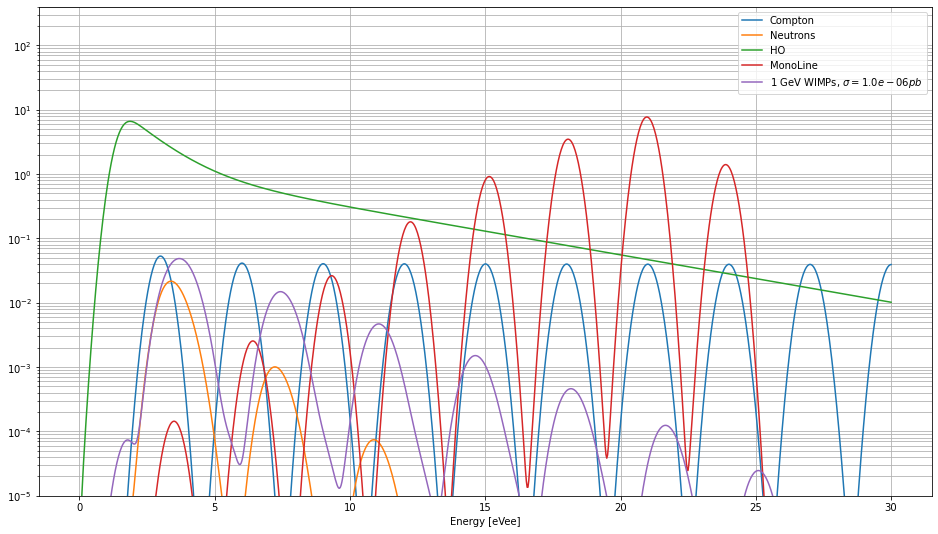

In [4]:
Emin, Emax, nptx, Energyscale = 0, 30, 1000, "eVee"
assert Energyscale in ["eV","eVee"]
logx = False
x = np.linspace(Emin,Emax,nptx) if logx==False else np.logspace(np.log10(Emin),np.log10(Emax),nptx)

Exp.Quantization = True

Compton = Spectrum("ER",Exp)
Compton.SetFunc(lambda x: np.ones_like(x)*1e-2,0,1e9)
ComptonEnergySpectrum = Compton.GetEphononSmearedFunc(Energyscale)

Neutrons = Spectrum("NR",Exp)
Neutrons.SetFunc(lambda x: np.exp(-0.1*x)*1e-2,0,1e9)
NeutronsEnergySpectrum = Neutrons.GetEphononSmearedFunc(Energyscale)
    
HeatOnly = Spectrum("HO",Exp)
HeatOnly.SetFunc(fonctionHOdivided1000,0,1e9)
HeatOnlyEnergySpectrum = HeatOnly.GetEphononSmearedFunc(Energyscale)
    
Monoline = Spectrum("monoER",Exp)
Monoline.SetLine(20,10)
MonolineEnergySpectrum = Monoline.GetEphononSmearedLine(Energyscale)



W = WIMP_Parameters()
W.WIMPmass = 1
W.CrossSection = 1e-6
Wimps = Spectrum(W,Exp)
WimpsEnergySpectrum = Wimps.GetEphononSmearedFunc(Energyscale)



fig, ax = plt.subplots(figsize=(16,9))
ax.plot(x,ComptonEnergySpectrum(x),label="Compton")
ax.plot(x,NeutronsEnergySpectrum(x),label="Neutrons")
ax.plot(x,HeatOnlyEnergySpectrum(x),label="HO")
ax.plot(x,MonolineEnergySpectrum(x),label="MonoLine")
ax.plot(x,WimpsEnergySpectrum(x),label=f"{W.WIMPmass} GeV WIMPs, $\sigma= {W.CrossSection:.1e} pb$ ")
ax.legend()
ax.grid(which='both')
ax.set_yscale('log')
ax.set_ylim(bottom=1e-5,top=4e2)
_ = ax.set_xlabel(f"Energy [{Energyscale}]")


Existing PoissonDataFile with 1000 precalculated values is used
final ROI list consists of 3 ROI(s)
[3.33,4.32] eV
[6.98,7.97] eV
[10.83,11.42] eV
Quantization :  True
10 vs  0.2912621359223301


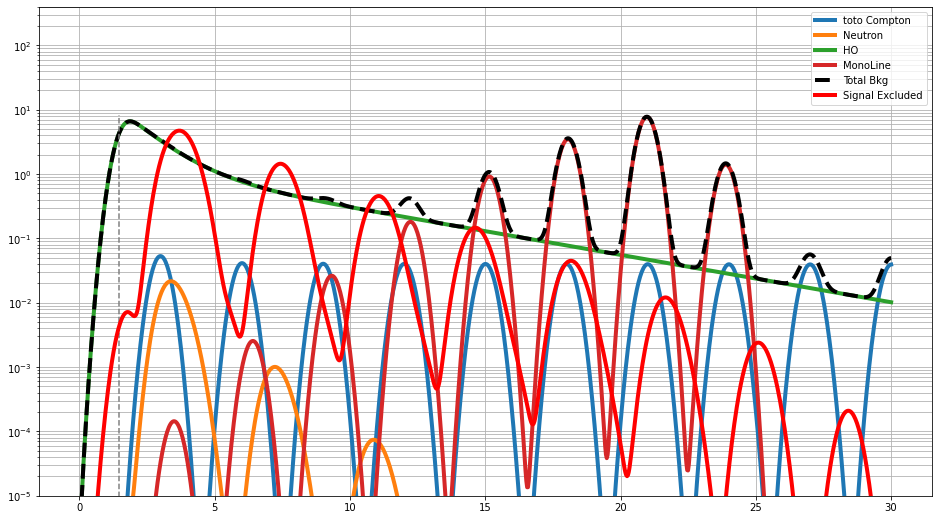

In [5]:
# Definition du range d'analyse (sorte de ROI préliminiraire)
AnalysisEmin = Exp.TriggerNsigma*Exp.SigmaeV if (Energyscale=="eV") else Exp.TriggerNsigma*Exp.SigmaeVee
AnalysisEmax = 100
AnalysisNptx = 1000 # plus c'est élevé, plus c'est précis mais plus c'est lent.

OR = Oracle(AnalysisEmin,AnalysisEmax,AnalysisNptx)

OR.AddBackground(ComptonEnergySpectrum, name="toto Compton")
OR.AddBackground(NeutronsEnergySpectrum,name="Neutron")
OR.AddBackground(HeatOnlyEnergySpectrum,name="HO")
OR.AddBackground(MonolineEnergySpectrum,name="MonoLine")

OR.AddSignal(WimpsEnergySpectrum)
OR.SetVariableOfInterest(W.CrossSection) # il faur préciser la valeur de la variable d'intérêt (section efficace dans le cas des WIMPs) pour le spectre qu'on a donné

fb = OR.GetTotalBackground()
fs = OR.GetSignal()


ROIlist = OR.CalculateROI_Bounds(fs,fb)
sigmaexcluded = OR.CalculateExcludedVariableOfInterest()
muexcluded = OR.GetExcludedMu()

# Affichage des spectres en énergie BKG
fig, ax = plt.subplots(figsize=(16,9))
for name in OR.GetBackgroundNames():
    tf1 = OR.GetBackground(name)
    ax.plot(x,tf1(x),label=name,lw=4)
ax.plot(x,fb(x),color="black",ls='--',label="Total Bkg",lw=4)
# Affichage de(s) ROI(s) utilisés
OR.PlotROIs()
OR.PlotThreshold()
    
# Affichage du spectre énergie des WIMPs pour la section efficace exclue
Wexcluded = copy.copy(W)
Wexcluded.CrossSection = sigmaexcluded
Wimpsexcluded = Spectrum(Wexcluded,Exp)
fsexcluded = Wimpsexcluded.GetEphononSmearedFunc(Energyscale)
ax.plot(x,fsexcluded(x),label="Signal Excluded",lw=4,color='red')
ax.set_yscale("log")
ax.grid(which='both')
ax.set_ylim(bottom=1e-5,top=4e2)
ax.legend()
# Affichage

Quantization :  True
20 vs  0.29556650246305416
Quantization :  True
20 vs  0.29556650246305416
Existing PoissonDataFile with 1000 precalculated values is used
Quantization :  True
20 vs  0.29556650246305416
final ROI list consists of 4 ROI(s)
[200.00,263.96] eV
[426.13,490.99] eV
[649.55,714.41] eV
[871.17,936.04] eV
[(200.0, 263.96396396396403), (426.1261261261261, 490.990990990991), (649.5495495495495, 714.4144144144145), (871.1711711711712, 936.0360360360361)]
mu excluded = 3.89e+00
cross section excluded 5.87e-05
Quantization :  True
20 vs  0.29556650246305416
done


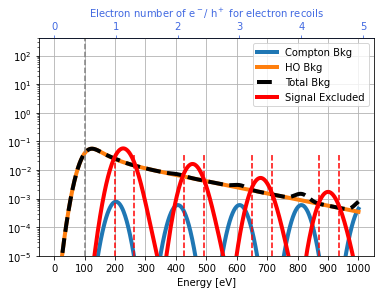

In [6]:
def ExampleOracle():
    
    Emin, Emax, nptx, Energyscale = 0, 1000, 1000, "eV"
    assert Energyscale in ["eV","eVee"]
    logx = False
    x = np.linspace(Emin,Emax,nptx) if logx==False else np.logspace(np.log10(Emin),np.log10(Emax),nptx)
    
    Exp = Experiment()
    Exp.Voltage = 200
    Exp.SigmaeV = 20
    Exp.Exposure = 1
    Exp.Fano = 0.15
    Exp.TriggerNsigma = 5
    
    Compton = Spectrum("ER",Exp)
    Compton.SetFunc(lambda x: np.ones_like(x)*1e-2,0,1e9)
    ComptonEnergySpectrum = Compton.GetEphononSmearedFunc(Energyscale)
    
    HeatOnly = Spectrum("HO",Exp)
    HeatOnly.SetFunc(fonctionHOdivided1000,0,1e9)
    HeatOnlyEnergySpectrum = HeatOnly.GetEphononSmearedFunc(Energyscale)
    
    Monoline = Spectrum("monoER",Exp)
    Monoline.SetLine(20.3,10)
    MonolineEnergySpectrum = Monoline.GetEphononSmearedLine(Energyscale)
    
    
    AnalysisEmin = Exp.TriggerNsigma*Exp.SigmaeV if (Energyscale=="eV") else Exp.TriggerNsigma*Exp.SigmaeVee
    AnalysisEmax = Emax
    AnalysisNptx = nptx # plus c'est élevé, plus c'est précis mais plus c'est lent.
    OR = Oracle(AnalysisEmin,AnalysisEmax,AnalysisNptx)
    #OR.AddBackground(MonolineEnergySpectrum,"Mono :)")
    OR.AddBackground(ComptonEnergySpectrum,"Compton Bkg")
    OR.AddBackground(HeatOnlyEnergySpectrum,"HO Bkg")
      
        
    W = WIMP_Parameters()
    W.WIMPmass = 1
    W.CrossSection = 1e-6
    Wimps = Spectrum(W,Exp)
    WimpsEnergySpectrum = Wimps.GetEphononSmearedFunc(Energyscale)
    OR.AddSignal(WimpsEnergySpectrum)
    OR.SetVariableOfInterest(W.CrossSection)
    
    fb = OR.GetTotalBackground()
    fs = OR.GetSignal()
    
    ROIlist = OR.CalculateROI_Bounds(fs,fb)#,AnalysisEmin,AnalysisEmax,AnalysisNptx)
    print(ROIlist)
    sigmaexcluded = OR.CalculateExcludedVariableOfInterest()
    muexcluded = OR.GetExcludedMu()
    print("mu excluded = {:.2e}".format(muexcluded))
    print("cross section excluded {:.2e}".format(sigmaexcluded))
    Wexcluded = copy.copy(W)
    Wexcluded.CrossSection = sigmaexcluded
    Wimpsexcluded = Spectrum(Wexcluded,Exp)
    
    
    ax = plt.subplots()
    for name in OR.GetBackgroundNames():
        tf1 = OR.GetBackground(name)
        plt.plot(x,tf1(x),label=name,lw=4)
        
    plt.plot(x,fb(x),color="black",ls='--',label="Total Bkg",lw=4)
    plt.locator_params("x",nbins=15)
    #plt.locator_params("y",nbins=15)
    
    plt.gca().set_ylim(bottom=1e-5,top=4E2)
    #plt.gca().set_yticks(np.logspace(-5, 2, 17))
    
    plt.yscale('log')
    if logx:
        plt.xscale('log')

    fsexcluded = Wimpsexcluded.GetEphononSmearedFunc(Energyscale)
    #plt.plot(x,fs(x),label="signal input",color="darkorange",lw=4)
    plt.plot(x,fsexcluded(x),label="Signal Excluded",lw=4,color='red')
  
    print("done")
    
    
    ax = plt.gca()
    if(Energyscale=="eVee"):
        ftransform = lambda x : x/Exp.Epsilon
        finv = lambda x : x*Exp.Epsilon
        secax = ax.secondary_xaxis('top', functions=(ftransform,finv))
    else:
        ftransform = lambda x : x/(1+Exp.Voltage/Exp.Epsilon)/Exp.Epsilon
        finv = lambda x : x*(1+Exp.Voltage/Exp.Epsilon)/Exp.Epsilon
        secax = ax.secondary_xaxis('top', functions=(ftransform,finv),color="royalblue")
     
    #ax.locator_params(tight=True, nbins=4)
    secax.set_xlabel('Electron number of e$^-$/ h$^+$ for electron recoils')
    plt.grid(True)
    plt.xlabel("Energy [eV]")
    plt.gca().yaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=15))
    OR.PlotROIs()
    OR.PlotThreshold()
    plt.legend()
    #plt.savefig("oracle.png")
    plt.show()
ExampleOracle()